#  AI CA5
# Neural Network 
## Name: Fatemeh Naeinian

### Student ID: 810099018


## Definition of project:
This project is an introduction to neural network. We will use numpy to build a multi layer fully connecetd with our definition. A 28 classes dataset is used in this project which we use 16 classes of it. We will analyse the impact of the different parameters such as activation function, learning rate and batch size.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# load dataset and preprocessing

- Each pixel of the photo has an amount between 0 and 255 so for normalization we need to divide them by 255.

- In the output layer there is one neuron for each class, and a Softmax activation function to output the proper class based on the probabilities of the input belonging to each class. The output of a Softmax is a vector with probabilities of each possible outcome. Using one-hot encoding forces the network to have a single high-activation output when a certain input is present.



In [3]:
x_train = pd.read_csv('/content/TrainImgs.csv')
y_train = pd.read_csv('/content/TrainLabels.csv')
x_test = pd.read_csv('/content/TestImgs.csv')
y_test = pd.read_csv('/content/TestLabels.csv')
y_train.columns = ['label']
y_test.columns = ['label']


In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(13439, 1024)
(13439, 1)
(3359, 1024)
(3359, 1)


In [5]:
print('classes : ',list(y_train['label'].unique()))

classes :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


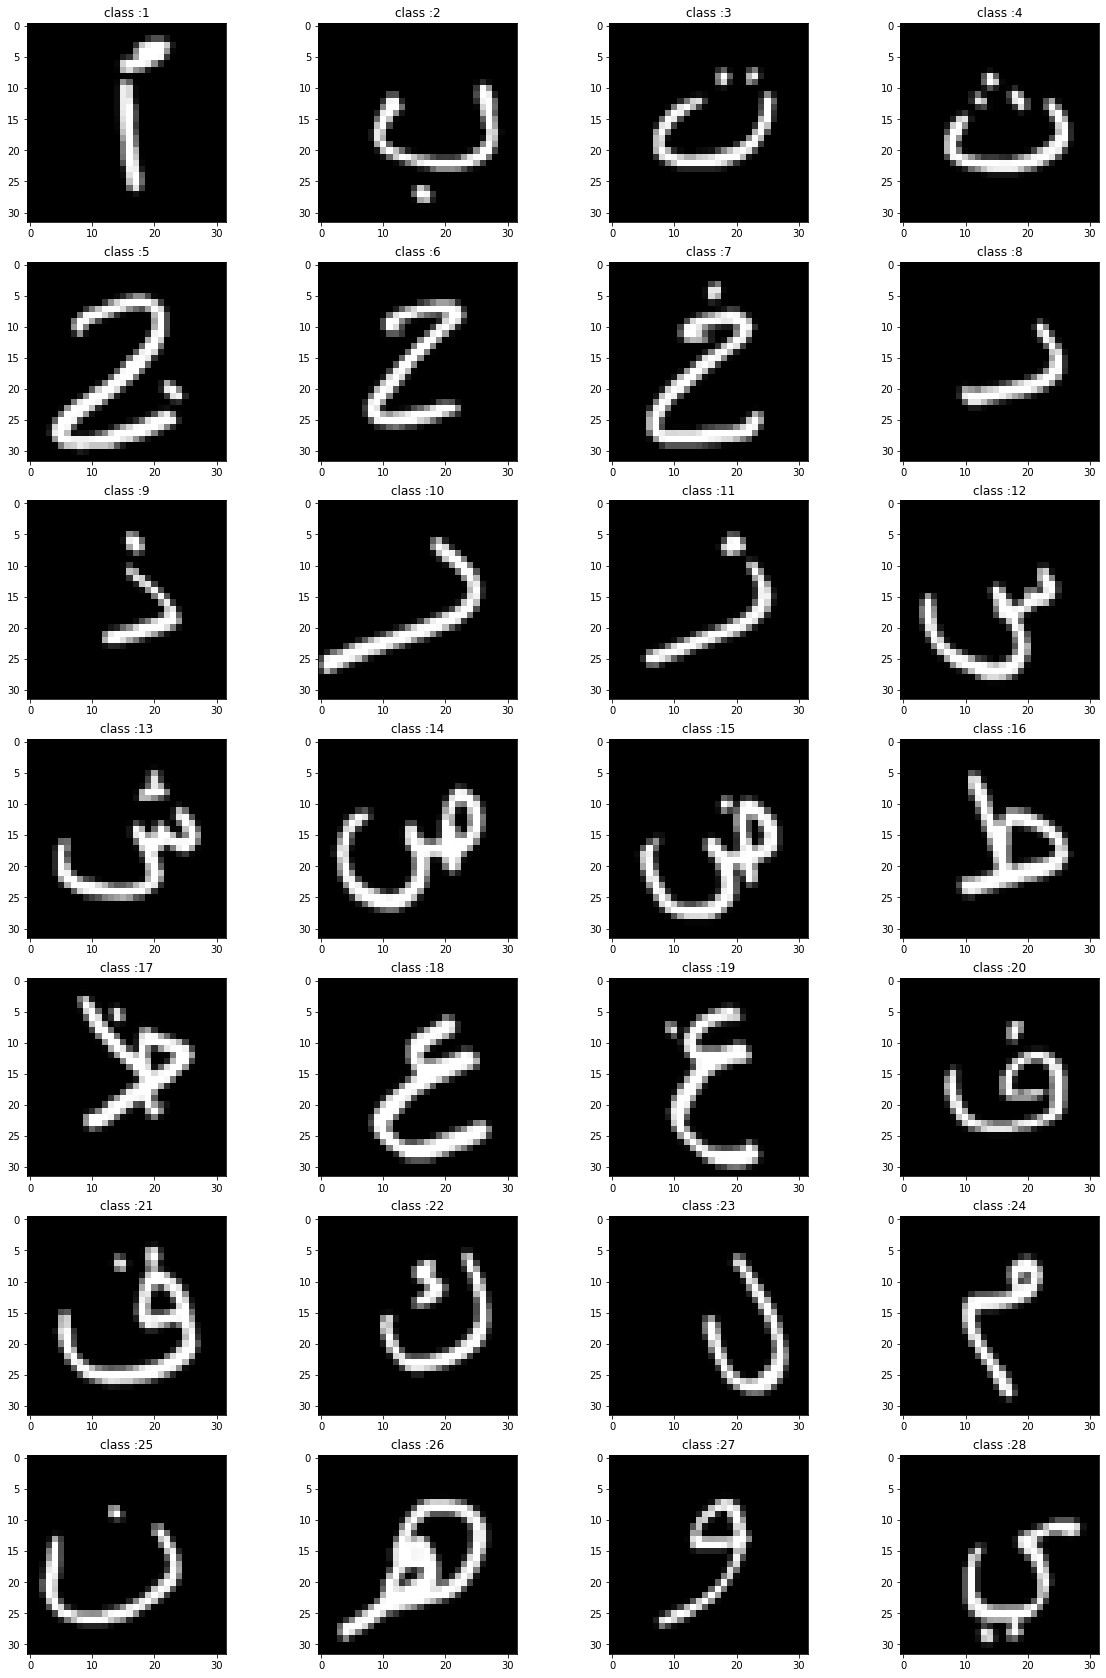

In [10]:
labels = list(y_train['label'].unique())

plt.figure(figsize=(20,30))
for l in labels:
  first_of_each_label = y_train.index[y_train['label'] == l][0]
  data = np.reshape(x_train.iloc[first_of_each_label].to_numpy(), (32,32))
  plt.subplot(7,4,l)
  plt.imshow(data.T, cmap=plt.cm.gray)
  plt.title('class :{}'.format(l))

In [11]:
Y_train = pd.DataFrame()
X_train = pd.DataFrame()
Y_test = pd.DataFrame()
X_test = pd.DataFrame()

We need to separate 16 classes of the dataset. 

In [12]:
selected_label = np.arange(1,17)
for l in list(selected_label):
  indexes_train = y_train.index[y_train['label'] == l]
  indexes_test = y_test.index[y_test['label'] == l]
  Y_train = Y_train.append(y_train.iloc[indexes_train])
  X_train = X_train.append(x_train.iloc[indexes_train])
  Y_test = Y_test.append(y_test.iloc[indexes_test])
  X_test = X_test.append(x_test.iloc[indexes_test])

In [13]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(7679, 1024)
(7679, 1)
(1919, 1024)
(1919, 1)


distribution of the dataset

Text(0.5, 1.0, 'Test Data')

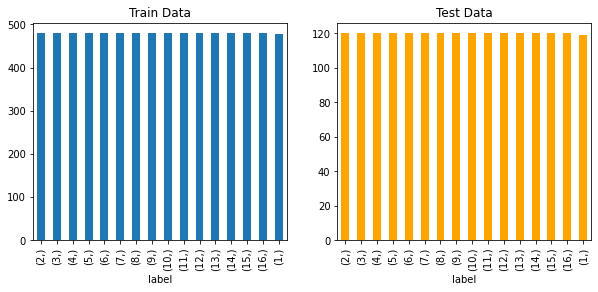

In [14]:
train_count = Y_train.value_counts()
test_count = Y_test.value_counts()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ax = train_count.plot(kind='bar')
plt.title("Train Data")
plt.subplot(1,2,2)
ax2 = test_count.plot(kind='bar', color='orange')
plt.title("Test Data")

Normalization 

In [15]:
X_train = X_train/255
X_test = X_test/255

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_train = Y_train.to_numpy().reshape(-1)
Y_test = Y_test.to_numpy().reshape(-1)

# Dataloader

In [27]:
class Dataloader:
    '''
    This class prepares the dataset for the neural network.
    '''
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        '''
        This is the constructor. It gets dataset information and initializes the 
        Dataloader class fields.
            Parameters:
                data: features your dataset in pandas.Dataframe format.
                labels: labels of your dataset in pandas.Dataframe format.
                n_classes: number of classes you have in your dataset.
                batch_size: the number of samples that will be propagated through the network.
                shuffle: boolean value indicating whether or not the dataset should be shuffled
        '''

        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        '''
        This private method gets labels and provides one_hot vectors of labels.
        For categorical variables where no such ordinal relationship exists,
        the integer encoding is not enough.
        In this case, a one-hot encoding can be applied to the integer representation.
        This is where the integer encoded variable is removed, and a new binary variable is
        added for each unique integer value.
        example:
            red,    green,    blue
            1,      0,        0
            0,      1,        0
            0,      0,        1
                Parameters:
                        label: lables of your dataset in pandas.Dataframe format.
                        n_classes: number of classes you have in your dataset.
                
                Returns:
                    onehot_vectors: onehot vectors of the labels
        '''
        onehot_vectors = np.eye(n_classes)[labels-1]
        return onehot_vectors
    
    def __shuffle_dataset(self):
        '''
        This private method shuffles your dataset.
        It uses data and onehot_labels to shuffle them
        symmetrical.
        '''
        indeces = np.arange(len(self.__data))
        np.random.shuffle(indeces)
        self.__data = self.__data[indeces]
        self.__onehot_labels = self.__onehot_labels[indeces]

    def __iter__(self):
        '''
        The __iter__() function returns an iterator for the
        given object (array, set, tuple, etc., or custom objects).
        This will return your dataset in the batch_size given. This should
        be used to provide data for the neural network.
        '''
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

# Activation Functions

In [28]:
class Identical:
    '''
    This is the Identical activation function. This activation function just
    return the value it gets.
    '''
    
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        As this is an identical activity function, it just 
        returns np.matrix of the input.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_value: np.matrix of input with float datatypes
        '''
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        '''
        This method returns the derivation of the input.
        As the derivation of x is one, this method returns
        a matrix of one with the shape of the input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                identical_derivative: np.matrix of ones with matrix shape
        '''
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _value method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    

class Relu:
    '''
    This is the Relu activation function. 
    The rectified linear activation function or ReLU for short
    is a piecewise linear function that will output the input directly
    if it is positive, otherwise, it will output zero.
    '''
    
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set 0 in the matrix if the value is less than 0 else, it returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        relu_value = np.matrix(matrix, dtype=float)
        relu_value = np.maximum(0, relu_value)
        return relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_derivative: np.matrix of relu activation function derivation result
        '''
        # TODO: Implement
        relu_derivative = np.matrix(matrix, dtype=float)
        relu_derivative[relu_derivative <= 0] = 0.0
        relu_derivative[relu_derivative > 0] = 1.0
        return relu_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _relu method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __relu(matrix): __relu return value for the input matrix
        '''
        return self.__val(matrix)

    
class LeakyRelu:
    '''
    This is the Leaky Relu activation function. 
    Leaky Rectified Linear Unit, or Leaky ReLU,
    is a type of activation function based on a ReLU,
    but it has a small slope for negative values instead
    of a flat slope.
    '''
    
    def __init__(self, negative_slope=0.01):
        '''
        This is the constructor.
        It sets negative_slope field.
            Parameters:
                negative_slope: slope for negative input values
        '''
        self.negative_slope = negative_slope
    
    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It will set negative_slope*value in the matrix if the value is less than 0, else it
        returns the value itself.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        leacky_relu_value = np.matrix(matrix, dtype=float)
        leacky_relu_value = np.maximum(self.negative_slope*leacky_relu_value, leacky_relu_value)        
        return leacky_relu_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of leaky relu function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                leacky_relu_derivative: np.matrix of leaky relu activation function derivation result
        '''
        # TODO: Implement
        leacky_relu_derivative = np.matrix(matrix, dtype=float)
        leacky_relu_derivative[leacky_relu_derivative > 0] = 1.0
        leacky_relu_derivative[leacky_relu_derivative <= 0] = self.negative_slope
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

    
class Sigmoid:
    '''
    A sigmoid function is a mathematical function having a
    characteristic "S"-shaped curve or sigmoid curve.
    It return S(x)=1/(1+e^-x)
    '''
    
    def __init__(self): pass

    def __val(self, matrix):
        '''
        Returns 1/(1+e^-x) of values
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        sigmoid_value = np.matrix(matrix, dtype=float)
        sigmoid_value = 1/(1 + np.exp(-sigmoid_value))
        return sigmoid_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of sigmoid function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of sigmoid activation function derivation result
        '''
        # TODO: Implement
        sigmoid_derivative = np.matrix(matrix, dtype=float)
        sigmoid_derivative = np.divide(np.exp(-sigmoid_derivative), np.power(1 + np.exp(-sigmoid_derivative), 2))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)





class Softmax:
    '''
    The softmax function, also known as softargmax  or normalized
    exponential function is a generalization of the logistic
    function to multiple dimensions. It is used in multinomial logistic
    regression and is often used as the last activation function of a neural
    network to normalize the output of a network to a probability distribution
    over predicted output classes, based on Luce's choice axiom.
    Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
    '''
        
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the softmax on that.
        Softmax return (e^x_i / (Σe^x_j for j = 1, ..., J))
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                relu_value: np.matrix of relu activation function result
        '''
        # TODO: Implement
        softmax_value = np.matrix(matrix, dtype=float)
        softmax_value = np.exp(softmax_value - np.max(softmax_value))
        softmax_value /= softmax_value.sum(axis=1)
        return softmax_value
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)
    
class Tanh:
    
    def __init__(self):
        '''
        This is the constructor. It does not have any fields
        as a result, there is no need to do anything in the constructor.
        '''
        pass

    def __val(self, matrix):
        '''
        This private method gets a matrix and uses the activity function on that.
        It performs Tanh on the values.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                tanh_value: np.matrix of Tanh activation function result
        '''
        # TODO: Implement
        tanh_value = np.matrix(matrix, dtype=float)
        tanh_value = np.tanh(tanh_value)
        return tanh_value

    def derivative(self, matrix):
        '''
        Returns the derivation value of Tanh function on input matrix.
        
            Parameters:
                matrix: np.matrix of values
            Returns:
                sigmoid_derivative: np.matrix of Tanh activation function derivation result
        '''
        # TODO: Implement
        tanh_derivative = np.matrix(matrix, dtype=float)
        tanh_derivative = np.power(np.divide(1, np.cosh(tanh_derivative)), 2)
        return tanh_derivative
    
    def __call__(self, matrix):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                matrix: np.matrix of values
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(matrix)

# Loss Function

In [29]:
class CrossEntropy: #(with softmax)
    '''
    Cross-entropy is a measure of the difference between two probability
    distributions for a given random variable or set of events. You might
    recall that information quantifies the number of bits required to encode
    and transmit an event.
    The above image can help you.
    '''
    
    def __init__(self): pass
        # '''
        # This is the constructor. It does not have any fields
        # as a result, there is no need to do anything in the constructor.
        # '''

    def __val(self, true_val, expected_val):
        '''
        L(y^, y) = - Σ (y^(k)log (y^)^(k)) for k in K
        Parameters:
            true_val: calculated values (generated by neural network)
            expected_val: real values in dataset
        Returns:
            cross_entropy_value: cross entropy of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        softmax = Softmax()
        cross_entropy_value = np.sum(-np.multiply(np.matrix(expected_val, dtype=float),  np.log(softmax(true_val))), axis=1)
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        '''
        Returns derivation of cross entropy.
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                cross_entropy_derivative: cross entropy derivation of inputs
        '''
        assert np.shape(true_val)==np.shape(expected_val)
        softmax = Softmax()
        cross_entropy_derivative = softmax(true_val) - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        '''
        __call__ is a special function in Python that, when implemented inside a class,
        gives its instances (objects) the ability to behave like a function.
        Here we return the _val method output.
            
            Parameters:
                true_val: calculated values (generated by neural network)
                expected_val: real values in dataset
            Returns:
                __val(matrix): __val return value for the input matrix
        '''
        return self.__val(true_val, expected_val)

# Layer

In [30]:
class Layer:
    '''
    The layer class is used to define neural network layers.
    It stores all needed information for each layer, such as neurons count,
    weight matrix, bias, the output after applying the activation function, etc.
    '''

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform', 
                 **initializing_parameters):
        '''
        Parameters:
            input_size: the size of the input of this layer.
            output_size: the size of the output after this layer.
            activation: the activation function. It can be initialized to either of the previously defined activation classes.
                               default is an Identical activation function.
            initial_weight: either normal or uniform. It defines the method for weight initialization.
        '''
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'


        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        '''
        It calculates the output of this layer for the layer_input argument.
        This method also stores __last_input, __last_activation_input, and __last_activation_derivative
        for future use in backpropagation.
        Parameters:
            layer_input: 2d np.matrix representing the input matrix of this layer.
        Returns:
            Final output of this layer after applying the activation function.
        '''
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)

        self.__last_input = layer_input
        self.__last_activation_input = np.add(np.dot(self.__last_input, self.__weight), self.__bias)
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_output)
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        '''
        It updates Layer weights according to the backpropagation matrix and learning rate.
        This method updates bias values as well.
        Parameters:
            backprop_tensor: 2d np.matrix passed from the next layer containing gradient values.
            lr: learning rate
        Returns:
            backprop_tensor to be used by the previous layer.
        '''
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        inputT = self.__last_input.T
        dy = np.multiply(backprop_tensor, self.__last_activation_derivative)
        backprop_tensor = np.matmul(dy, self.__weight.T)
        self.__weight -= np.matmul(inputT, dy) * lr
        self.__bias -= np.matmul(np.matrix(np.tile(1, (1, dy.shape[0]))), dy) * lr
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a uniform distribution between low and high values.
        It uses default low and high values unless low or high are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom low or high values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using uniformly distributed values.
        '''
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = np.random.uniform(low=low, high=high, size=(dim1, dim2))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        '''
        Initializes weights as a normal distribution with mean and var values.
        It uses default mean and variance values unless mean or var are passed in initializing_parameters.
        Parameters:
            dim1: the size of the first dimension of weights.
            dim2: the size of the second dimension of weights.
            initializing_parameters: other initializing parameters; it can include custom mean or var values.
        Returns:
            np.matrix with size (dim1, dim2) initialized using normaly distributed values.
        ''' 
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = np.random.normal(loc=mean, scale=np.sqrt(var), size=(dim1,dim2))
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

# Feed Forward Neural Network

In [31]:
class FeedForwardNN:
    '''
    This class is used in order to implement custom feed-forward neural networks.
    The FeedForwardNN class stores a list of layers that determines all network layers.
    It also consists of the learning rate and loss function.
    '''
    def __init__(self, input_shape):
        '''
        Parameters:
            input_shape: the size of the first input to our neural network.
        '''
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
        '''
         This method adds a new custom layer to the layers_list.
         Parameters:
             n_neurons: number of neurons in this layer
             activation: the activation function of this layer, default is Relu
             initial_weight: either a uniform or normal, default is uniform
             initializing_parameters: other initializing parameters such as low, high, mean, var, etc
        '''
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        '''
        This method is used to set training parameters.
        Parameters:
            loss: loss function, default is CrossEntropy
            lr: learning rate, default is 1e-3
        '''
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        '''
        This method calculates the output of the complete neural network for a passed input.
        Parameters:
            network_input: input of the neural network
        Returns:
            network_output: output of the neural network after forwarding the network_input
        '''
        assert type(self.__output_shape) != None, "Model is not compiled!"
        network_output = network_input
        for layer in self.__layers_list :
          network_output = layer.forward(network_output)
        return network_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        '''
        This method trains the neural network using specified parameters.
        It runs the __train private method epoch times and fills the log dictionary.
        Parameters:
            epochs: number of epochs to run
            trainloader: DataLoader for train data
            testloader: DataLoader for test data
            print_results: whether or not to print the results
        Returns:
            log: complete log of the training process as a dictionary consisting of
            train_accuracy, train_loss, test_accuracy, test_loss
        '''
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        '''
        Trains the neural network for one epoch.
        Parameters:
            trainloader: A DataLoader consisting of train data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        '''
        Test the neural network using a testloader.
        Parameters:
            testloader: A DataLoader of test data
        Returns:
            batch_accuracy, batch_loss: mean of all batch_accuracies, batch_losses
        '''
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        '''
        Trains the neural network for one batch of train data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''
        out = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(out,y_batch)
        batch_average_loss = self.__update_weights(out, y_batch)
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        '''
        Tests the neural network for one batch of test data.
        Parameters:
            x_batch: one batch data
            y_batch: labels for one batch
        Returns:
            (batch_accuracy, batch_average_loss)
        '''  
        out = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(out,y_batch)
        cross_entropy = CrossEntropy()
        batch_loss = cross_entropy(out, y_batch)
        batch_average_loss = np.sum(batch_loss)/len(out)        
        return (batch_accuracy, batch_average_loss)
            
        
    def __get_labels(self, outputs):
        '''
        Parameters:
            outputs: output of the neural network
        Returns:
            labels: labels generated from the outputs of the neural network
        '''
        labels = np.argmax(outputs, axis=1)
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        '''
        Computes accuracy by comparing output and expected_output.
        Parameters:
            output: actual output of the neural network
            expected_output: expected output
        Returns:
            accuracy
        '''
        accuracy = ((self.__get_labels(output) == self.__get_labels(expected_output)).sum()/len(output)) * 100
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        '''
        Updates weights of all layers according to neural network output and labels.
        Parameters:
            output: output of the neural network
            y_train: y labels for one batch of train data
        Returns:
            None
        '''
        cross_entropy = CrossEntropy()
        batch_loss = cross_entropy(output, y_train)
        batch_average_loss = np.sum(batch_loss)/len(output)
        temp = cross_entropy.derivative(output, y_train)
        for i in reversed(self.__layers_list):
            temp = i.update_weights(temp, self.__lr)
        return batch_average_loss

# Training Sample Code



In [32]:
def training(LEARNING_RATE = 0.005,   BATCH_SIZE = 32, ac_func = Relu()):
  INPUT_SHAPE = X_train.shape[1]
  EPOCHS = 100

  TRAINLOADER = Dataloader(X_train, Y_train, n_classes=16, batch_size=BATCH_SIZE, shuffle=True)
  TESTLOADER = Dataloader(X_test, Y_test, n_classes=16, batch_size=BATCH_SIZE, shuffle=True)


  network = FeedForwardNN(INPUT_SHAPE)
  network.add_layer(50, input_shape=INPUT_SHAPE, activation=ac_func, weight_initializer='uniform')
  network.add_layer(20, activation=ac_func, weight_initializer='uniform')
  network.add_layer(16, activation=Identical(), weight_initializer='uniform')
  network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

  log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

# part 1

training with given hyper parameters:
- learning rate : 0.005
- epoch : 100
- batch_size : 32
- activation function : Relu()


In [33]:
training()

Epoch 1:
	Train: Average Accuracy: 10.339381720430108	Average Loss: 2.6526574280099635
	Test: Average Accuracy: 13.595430107526882	Average Loss: 2.5162946562386272
Epoch 2:
	Train: Average Accuracy: 19.037718413978496	Average Loss: 2.2978842918702
	Test: Average Accuracy: 23.551747311827956	Average Loss: 2.0832625436227277
Epoch 3:
	Train: Average Accuracy: 27.515961021505372	Average Loss: 1.9541375290163845
	Test: Average Accuracy: 32.46639784946237	Average Loss: 1.8251452242684967
Epoch 4:
	Train: Average Accuracy: 33.728158602150536	Average Loss: 1.7619459226078817
	Test: Average Accuracy: 39.33971774193549	Average Loss: 1.6225779777049303
Epoch 5:
	Train: Average Accuracy: 40.92993951612903	Average Loss: 1.5423713436161544
	Test: Average Accuracy: 44.60685483870967	Average Loss: 1.4773727540830974
Epoch 6:
	Train: Average Accuracy: 48.54796706989247	Average Loss: 1.3514226448069708
	Test: Average Accuracy: 52.06317204301076	Average Loss: 1.2565770250251176
Epoch 7:
	Train: Average 

# part 2

<b>Zero Initialization:</b> If we initializ all the weights with 0, then the derivative of loss function is the same for all weight, thus all weights have the same value in subsequent iterations. This makes hidden layers symmetric and this process continues for all the n iterations. Thus initialized weights with zero make your network act like a linear model.

<b>Random Initialization:</b>  This technique tries to address the problems of zero initialization since it prevents neurons from learning the same features of their inputs since our goal is to make each neuron learn different functions of its input and this technique gives much better accuracy than zero initialization.<br/>

# part 3

If the learning rate is too low, learning will be very slow, beacause every time a very tiny amount of update applies on the weights in the network.

If the learning rate is set too high, it can cause undesirable divergent behavior in the loss function.

As we can see the results, among 0.05, 0.005 and 0.0005, 0.005 has better result and we use it as default learning rate.

This model has these parameters:
- learning rate : 0.05
- epoch : 100
- batch_size : 32
- activation function : Relu()

In [34]:
training(LEARNING_RATE = 0.05)

Epoch 1:
	Train: Average Accuracy: 5.978242607526882	Average Loss: 2.8158759742112665
	Test: Average Accuracy: 6.253360215053763	Average Loss: 2.7801109264242334
Epoch 2:
	Train: Average Accuracy: 6.236979166666667	Average Loss: 2.7863736069672753
	Test: Average Accuracy: 6.253360215053763	Average Loss: 2.784165987615698
Epoch 3:
	Train: Average Accuracy: 5.808131720430108	Average Loss: 2.7866767667762766
	Test: Average Accuracy: 6.253360215053763	Average Loss: 2.7844356956831064
Epoch 4:
	Train: Average Accuracy: 5.807291666666667	Average Loss: 2.7864148191086455
	Test: Average Accuracy: 6.253360215053763	Average Loss: 2.7843339497013093
Epoch 5:
	Train: Average Accuracy: 6.341565860215054	Average Loss: 2.7865785681333497
	Test: Average Accuracy: 6.253360215053763	Average Loss: 2.7803677641933975
Epoch 6:
	Train: Average Accuracy: 6.094590053763441	Average Loss: 2.7852960116543874
	Test: Average Accuracy: 6.251680107526882	Average Loss: 2.785781288998857
Epoch 7:
	Train: Average Accur

This model has these parameters:
- learning rate : 0.005
- epoch : 100
- batch_size : 32
- activation function : Relu()


In [35]:
training(LEARNING_RATE = 0.005)

Epoch 1:
	Train: Average Accuracy: 9.922715053763442	Average Loss: 2.652968560708882
	Test: Average Accuracy: 13.130040322580644	Average Loss: 2.514390134536383
Epoch 2:
	Train: Average Accuracy: 13.54544690860215	Average Loss: 2.447549553691909
	Test: Average Accuracy: 15.737567204301076	Average Loss: 2.315280029977368
Epoch 3:
	Train: Average Accuracy: 26.476394489247312	Average Loss: 2.001659740126866
	Test: Average Accuracy: 32.825940860215056	Average Loss: 1.785708097610327
Epoch 4:
	Train: Average Accuracy: 34.899193548387096	Average Loss: 1.726301480028055
	Test: Average Accuracy: 36.11391129032258	Average Loss: 1.6775111673068337
Epoch 5:
	Train: Average Accuracy: 41.51587701612903	Average Loss: 1.5437004364574547
	Test: Average Accuracy: 45.70060483870967	Average Loss: 1.4905714845402327
Epoch 6:
	Train: Average Accuracy: 50.11088709677419	Average Loss: 1.333661534300834
	Test: Average Accuracy: 53.103158602150536	Average Loss: 1.2912131247994576
Epoch 7:
	Train: Average Accur

This model has these parameters:
- learning rate : 0.0005
- epoch : 100
- batch_size : 32
- activation function : Relu()


In [36]:
training(LEARNING_RATE = 0.0005)

Epoch 1:
	Train: Average Accuracy: 6.589381720430108	Average Loss: 2.734415163684814
	Test: Average Accuracy: 6.255040322580645	Average Loss: 2.723359642644883
Epoch 2:
	Train: Average Accuracy: 6.198336693548387	Average Loss: 2.7184637558993305
	Test: Average Accuracy: 6.409610215053763	Average Loss: 2.7047333443885164
Epoch 3:
	Train: Average Accuracy: 6.393649193548387	Average Loss: 2.7020123099693403
	Test: Average Accuracy: 6.564180107526882	Average Loss: 2.689782740442031
Epoch 4:
	Train: Average Accuracy: 7.175319220430108	Average Loss: 2.6847186489929364
	Test: Average Accuracy: 9.380040322580644	Average Loss: 2.671432792450389
Epoch 5:
	Train: Average Accuracy: 8.881468413978496	Average Loss: 2.6677656091747526
	Test: Average Accuracy: 10.10920698924731	Average Loss: 2.653677376938838
Epoch 6:
	Train: Average Accuracy: 9.87357190860215	Average Loss: 2.6496851354420743
	Test: Average Accuracy: 10.68380376344086	Average Loss: 2.6348942094506147
Epoch 7:
	Train: Average Accuracy:

# part 4

- As we can see, LeakyRelu and Relu have better result than Sigmoid and Tanh. Although both sigmoid and tanh functions have the problem of vanishing gradient, because tanh is symmetric to zero and this prevents its gradient from moving in a specific direction, it often uses tanh in practice. In practice the tanh non-linearity is always preferred to the sigmoid nonlinearity.

- LeakyReLU has two benefits:<br/>
1- It fixes the “dying ReLU”(The downside for being zero for all negative values is a problem called “dying ReLU.”) problem, as it doesn’t have zero-slope parts.<br/>
2- It speeds up training. There is evidence that having the “mean activation” be close to 0 makes training faster. 

There is not much difference here and we can say that using Leaky Relu instead of Relu will probably result in same accuracy based on the provided dataset. One advantage that Leaky Relu has is that it performs a better update. When negative values are give to Relu it is absolutely certain that derivative is zero so there will be no change at all.
    



This model has these parameters:
- learning rate : 0.005
- epoch : 100
- batch_size : 32
- activation function : Sigmoid()

In [37]:
training(LEARNING_RATE = 0.005, ac_func=Sigmoid())

Epoch 1:
	Train: Average Accuracy: 5.911878360215054	Average Loss: 2.786345530661474
	Test: Average Accuracy: 6.25	Average Loss: 2.778776841684613
Epoch 2:
	Train: Average Accuracy: 6.577200940860215	Average Loss: 2.7826936076736946
	Test: Average Accuracy: 6.253360215053763	Average Loss: 2.783168296897072
Epoch 3:
	Train: Average Accuracy: 6.302923387096774	Average Loss: 2.7799841075070044
	Test: Average Accuracy: 6.251680107526882	Average Loss: 2.7743208213985615
Epoch 4:
	Train: Average Accuracy: 6.510836693548387	Average Loss: 2.7743734233389024
	Test: Average Accuracy: 6.359206989247312	Average Loss: 2.7651638682469515
Epoch 5:
	Train: Average Accuracy: 7.344590053763441	Average Loss: 2.7659965587117843
	Test: Average Accuracy: 7.977150537634409	Average Loss: 2.7603939399730586
Epoch 6:
	Train: Average Accuracy: 8.333753360215054	Average Loss: 2.7615516307287207
	Test: Average Accuracy: 7.972110215053763	Average Loss: 2.757324387811436
Epoch 7:
	Train: Average Accuracy: 7.59240591

This model has these parameters:
- learning rate : 0.005
- epoch : 100
- batch_size : 32
- activation function : Tanh()


In [38]:
training(LEARNING_RATE = 0.005, ac_func=Tanh())

Epoch 1:
	Train: Average Accuracy: 7.476058467741935	Average Loss: 2.7508632429682627
	Test: Average Accuracy: 11.88508064516129	Average Loss: 2.690455292755018
Epoch 2:
	Train: Average Accuracy: 11.615843413978496	Average Loss: 2.499701263045039
	Test: Average Accuracy: 13.449260752688172	Average Loss: 2.3504373128307194
Epoch 3:
	Train: Average Accuracy: 16.878780241935484	Average Loss: 2.2692813936422227
	Test: Average Accuracy: 24.126344086021504	Average Loss: 2.0383643692774647
Epoch 4:
	Train: Average Accuracy: 26.74731182795699	Average Loss: 1.9250629788865032
	Test: Average Accuracy: 31.216397849462364	Average Loss: 1.8225711237710618
Epoch 5:
	Train: Average Accuracy: 35.04536290322581	Average Loss: 1.7454088343801615
	Test: Average Accuracy: 38.08971774193549	Average Loss: 1.6288410926189354
Epoch 6:
	Train: Average Accuracy: 40.60357862903226	Average Loss: 1.5390782811822714
	Test: Average Accuracy: 43.098118279569896	Average Loss: 1.4647907386101306
Epoch 7:
	Train: Average

This model has these parameters:
- learning rate : 0.005
- epoch : 100
- batch_size : 32
- activation function : LeakyRelu()


In [39]:
training(LEARNING_RATE = 0.005, ac_func=LeakyRelu())

Epoch 1:
	Train: Average Accuracy: 9.845850134408602	Average Loss: 2.6496005322511933
	Test: Average Accuracy: 10.74092741935484	Average Loss: 2.5502176467998265
Epoch 2:
	Train: Average Accuracy: 16.344086021505376	Average Loss: 2.381072935449941
	Test: Average Accuracy: 24.285954301075268	Average Loss: 2.105919089692456
Epoch 3:
	Train: Average Accuracy: 26.617943548387096	Average Loss: 1.979641913119351
	Test: Average Accuracy: 31.7372311827957	Average Loss: 1.8029784892204368
Epoch 4:
	Train: Average Accuracy: 33.05191532258065	Average Loss: 1.7519532043834098
	Test: Average Accuracy: 32.405913978494624	Average Loss: 1.7201965669326589
Epoch 5:
	Train: Average Accuracy: 38.027553763440864	Average Loss: 1.586593389797432
	Test: Average Accuracy: 40.43346774193549	Average Loss: 1.5107414136649528
Epoch 6:
	Train: Average Accuracy: 44.746723790322584	Average Loss: 1.4207978238402343
	Test: Average Accuracy: 45.337701612903224	Average Loss: 1.3805832485638838
Epoch 7:
	Train: Average A

# part 5

The batch size defines the number of samples that will be propagated through the network. Batch size controls the accuracy of the estimate of the error gradient when training neural networks. There is a tension between batch size and the speed and stability of the learning process. 

By using small batches, time taken to reach an answer will be significantly higher. There is also the problem of not having good choices. Small batches mean a small amount of selected data to do the prediction and who knows whether those selected ones can have a good generalization or not. By using big batches we are guaranteed that time taken will be short but since updates are being made at a much lower rate we might get stuck somewhere we do not want!


  
**As we can see below, result for 16 and 32 batch are almost similar to each other and for 256 batch is less than these two batches. The reasons has been said in previous question.**

This model has these parameters:
- learning rate : 0.005
- epoch : 100
- batch_size : 16
- activation function : LeakyRelu()


In [40]:
training(LEARNING_RATE = 0.005, ac_func=LeakyRelu(), BATCH_SIZE=16)

Epoch 1:
	Train: Average Accuracy: 9.6640625	Average Loss: 2.6520880113655645
	Test: Average Accuracy: 12.611111111111112	Average Loss: 2.5231638281987263
Epoch 2:
	Train: Average Accuracy: 16.407118055555557	Average Loss: 2.3705970931307765
	Test: Average Accuracy: 23.1875	Average Loss: 2.0574272205438597
Epoch 3:
	Train: Average Accuracy: 27.150173611111107	Average Loss: 1.9749305800652412
	Test: Average Accuracy: 31.94097222222222	Average Loss: 1.8456531598618544
Epoch 4:
	Train: Average Accuracy: 34.482638888888886	Average Loss: 1.766881183467084
	Test: Average Accuracy: 42.684027777777786	Average Loss: 1.634087989616409
Epoch 5:
	Train: Average Accuracy: 44.003472222222214	Average Loss: 1.5080940389385131
	Test: Average Accuracy: 50.59375	Average Loss: 1.3636306407416279
Epoch 6:
	Train: Average Accuracy: 52.14149305555555	Average Loss: 1.2730967993001014
	Test: Average Accuracy: 52.06944444444445	Average Loss: 1.2138068828227095
Epoch 7:
	Train: Average Accuracy: 57.1944444444444

This model has these parameters:
- learning rate : 0.005
- epoch : 100
- batch_size : 32
- activation function : LeakyRelu()


In [41]:
training(LEARNING_RATE = 0.005, ac_func=LeakyRelu(), BATCH_SIZE=32)

Epoch 1:
	Train: Average Accuracy: 9.573252688172042	Average Loss: 2.659150712996734
	Test: Average Accuracy: 13.805443548387098	Average Loss: 2.5380243261313193
Epoch 2:
	Train: Average Accuracy: 15.561155913978496	Average Loss: 2.4027327410833355
	Test: Average Accuracy: 24.128024193548388	Average Loss: 2.0920531321520044
Epoch 3:
	Train: Average Accuracy: 25.981602822580648	Average Loss: 1.9958250104905015
	Test: Average Accuracy: 30.226814516129032	Average Loss: 1.8620464836021682
Epoch 4:
	Train: Average Accuracy: 32.46597782258065	Average Loss: 1.77253654710393
	Test: Average Accuracy: 37.25974462365591	Average Loss: 1.6578496973682249
Epoch 5:
	Train: Average Accuracy: 39.44472446236559	Average Loss: 1.582694478073698
	Test: Average Accuracy: 40.53931451612903	Average Loss: 1.5198499990661232
Epoch 6:
	Train: Average Accuracy: 47.050571236559136	Average Loss: 1.3889350794881443
	Test: Average Accuracy: 49.24731182795699	Average Loss: 1.3183831405049515
Epoch 7:
	Train: Average A

This model has these parameters:
- learning rate : 0.005
- epoch : 100
- batch_size : 256
- activation function : LeakyRelu()


In [42]:
training(LEARNING_RATE = 0.005, ac_func=LeakyRelu(), BATCH_SIZE=256)

Epoch 1:
	Train: Average Accuracy: 6.315921160130719	Average Loss: 2.7958129269894325
	Test: Average Accuracy: 7.039708415354331	Average Loss: 2.768042684261629
Epoch 2:
	Train: Average Accuracy: 6.954146241830065	Average Loss: 2.767452380029769
	Test: Average Accuracy: 10.360789862204724	Average Loss: 2.7635371148560077
Epoch 3:
	Train: Average Accuracy: 6.823682598039215	Average Loss: 2.762097962871278
	Test: Average Accuracy: 8.503783218503937	Average Loss: 2.756748510715903
Epoch 4:
	Train: Average Accuracy: 8.373059640522875	Average Loss: 2.7530366046083494
	Test: Average Accuracy: 6.599486343503937	Average Loss: 2.7449851038058832
Epoch 5:
	Train: Average Accuracy: 9.871068218954248	Average Loss: 2.7377330840268908
	Test: Average Accuracy: 10.655296505905511	Average Loss: 2.723089039111313
Epoch 6:
	Train: Average Accuracy: 10.770731209150329	Average Loss: 2.711805542928539
	Test: Average Accuracy: 11.925596702755906	Average Loss: 2.6890630113643557
Epoch 7:
	Train: Average Accur